In [ ]:
import numpy as np
import scipy as sp
import sympy as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
CA0 = np.array([1, 4, 6, 8, 12, 15, 20]) * 1e-3   # mmol/L -> mol/L
rates_CB3 = np.array([0.000124, 0.00015, 0.000154, 0.000156, 0.000158, 0.000158, 0.000159])
rates_CB2 = np.array([7.02E-05, 8.49E-05, 8.7E-05, 8.8E-05, 8.91E-05, 8.95E-05, 9E-05])
rates_CB1 = np.array([4.9E-05, 5.92E-05, 6.06E-05, 6.13E-05, 6.21E-05, 6.24E-05, 6.27E-05])

CB0_levels = np.array([0.3, 0.2, 0.1])  # mol/L (for each set)

In [ ]:
A = np.concatenate([CA0, CA0, CA0])
B = np.concatenate([np.full_like(CA0, CB0_levels[0]),
                    np.full_like(CA0, CB0_levels[1]),
                    np.full_like(CA0, CB0_levels[2])])
v_obs = np.concatenate([rates_CB3, rates_CB2, rates_CB1])

In [ ]:
A, B, v_obs

(array([0.001, 0.004, 0.006, 0.008, 0.012, 0.015, 0.02 , 0.001, 0.004,
        0.006, 0.008, 0.012, 0.015, 0.02 , 0.001, 0.004, 0.006, 0.008,
        0.012, 0.015, 0.02 ]),
 array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 array([1.24e-04, 1.50e-04, 1.54e-04, 1.56e-04, 1.58e-04, 1.58e-04,
        1.59e-04, 7.02e-05, 8.49e-05, 8.70e-05, 8.80e-05, 8.91e-05,
        8.95e-05, 9.00e-05, 4.90e-05, 5.92e-05, 6.06e-05, 6.13e-05,
        6.21e-05, 6.24e-05, 6.27e-05]))

In [ ]:
eps = 1e-20

# np.set_printoptions(precision=6, suppress=True)

In [ ]:
def solve(X, y):
    G = X.T @ X                # Gram matrix (n x n)
    rhs = X.T @ y              # RHS vector (n,)
    try:
        Ginv = np.linalg.inv(G)
    except np.linalg.LinAlgError:
        print("Gram matrix singular -> using pseudo-inverse")
        Ginv = np.linalg.pinv(G)
    coeffs = Ginv @ rhs
    return {'G': G, 'Ginv': Ginv, 'rhs': rhs, 'coeffs': coeffs}

In [ ]:
y = 1.0 / (v_obs + eps)

## Simple LinAlg

### Bi Substrate

In [ ]:
X_bi = np.vstack([
    1 / (A * B + eps),   # x
    1 / (B + eps),       # y
    1 / (A + eps),       # z
    np.ones_like(A)        # const
]).T
y_bi = 1 / (v_obs + eps)

In [ ]:
X_bi = X_bi.T
np.shape(X_bi),X_bi[0]

((4, 21),
 array([ 3333.33333333,   833.33333333,   555.55555556,   416.66666667,
          277.77777778,   222.22222222,   166.66666667,  5000.        ,
         1250.        ,   833.33333333,   625.        ,   416.66666667,
          333.33333333,   250.        , 10000.        ,  2500.        ,
         1666.66666667,  1250.        ,   833.33333333,   666.66666667,
          500.        ]))

In [ ]:
Xisq = np.sum(X_bi[0]**2)
Xiyi = np.sum(X_bi[0] * X_bi[1])
Xizi = np.sum(X_bi[0] * X_bi[2])
Xi = np.sum(X_bi[0] * X_bi[3])
Yisq = np.sum(X_bi[1]**2)
Yizi = np.sum(X_bi[1] * X_bi[2])
Yi = np.sum(X_bi[1] * X_bi[3])
Zisq = np.sum(X_bi[2]**2)
Zi = np.sum(X_bi[2] * X_bi[3])
N = np.sum(X_bi[3]**2)

In [ ]:
y_bi,np.shape(y_bi)

(array([ 8064.51612903,  6666.66666667,  6493.50649351,  6410.25641026,
         6329.11392405,  6329.11392405,  6289.3081761 , 14245.01424501,
        11778.56301531, 11494.25287356, 11363.63636364, 11223.34455668,
        11173.18435754, 11111.11111111, 20408.16326531, 16891.89189189,
        16501.65016502, 16313.2137031 , 16103.05958132, 16025.64102564,
        15948.96331738]),
 (21,))

In [ ]:
Wixi = np.sum(X_bi[0] * y_bi)
Wiyi = np.sum(X_bi[1] * y_bi)
Wizi = np.sum(X_bi[2] * y_bi)
Wi = np.sum(X_bi[3] * y_bi)

In [ ]:
weighted_sums = np.array([Wixi,Wiyi,Wizi,Wi])
np.shape(weighted_sums),weighted_sums

((4,), array([4.83019241e+08, 1.74914630e+06, 6.82683889e+07, 2.47164171e+05]))

In [ ]:
#res_bi_manual = solve(X_bi, y_bi)
G = np.array([[Xisq,Xiyi,Xizi,Xi],[Xiyi,Yisq,Yizi,Yi],[Xizi,Yizi,Zisq,Zi],[Xi,Yi,Zi,N]])

G, np.linalg.inv(G)

(array([[1.52416088e+08, 2.37060185e+05, 2.05295139e+07, 3.19305556e+04],
        [2.37060185e+05, 9.52777778e+02, 3.19305556e+04, 1.28333333e+02],
        [2.05295139e+07, 3.19305556e+04, 3.35937500e+06, 5.22500000e+03],
        [3.19305556e+04, 1.28333333e+02, 5.22500000e+03, 2.10000000e+01]]),
 array([[ 6.05121387e-08, -1.50559964e-05, -3.69796403e-07,
          9.20088669e-05],
        [-1.50559964e-05,  9.68014123e-03,  9.20088669e-05,
         -5.91564186e-02],
        [-3.69796403e-07,  9.20088669e-05,  2.74545814e-06,
         -6.83096133e-04],
        [ 9.20088669e-05, -5.91564186e-02, -6.83096133e-04,
          4.39191593e-01]]))

In [ ]:
Sol = np.linalg.inv(G)@weighted_sums
a_bi, b_bi, c_bi, d_bi = Sol
a_bi, b_bi, c_bi, d_bi

(np.float64(0.3892775748043924),
 np.float64(1319.5971934675463),
 np.float64(0.9093058172109068),
 np.float64(2887.3758370204014))

In [ ]:
Vmax_bi = 1 / d_bi if d_bi != 0 else np.nan
K_AB = b_bi * Vmax_bi
K_BA = c_bi * Vmax_bi
K_A = (a_bi * Vmax_bi / K_AB) if (K_AB != 0) else np.nan

In [ ]:
X_bi = X_bi.T
np.shape(X_bi)

(21, 4)

In [ ]:
y_bi_pred = X_bi @ Sol
v_bi_pred = 1 / y_bi_pred
resid_bi = v_obs.mean() - v_bi_pred
ssr_bi = np.sum(resid_bi**2)                            # residual sum of squares
r2_bi = 1 - ssr_bi / np.sum((v_obs - v_obs.mean())**2)  # R^2
rmse_bi = np.sqrt(ssr_bi / (len(v_obs)))            # root mean square error

In [ ]:
v_bi_pred

array([1.05341544e-04, 1.27587513e-04, 1.30653210e-04, 1.32241978e-04,
       1.33869861e-04, 1.34532291e-04, 1.35201310e-04, 8.10303463e-05,
       9.80460863e-05, 1.00388395e-04, 1.01602025e-04, 1.02845358e-04,
       1.03351253e-04, 1.03862151e-04, 4.78802702e-05, 5.78574189e-05,
       5.92287422e-05, 5.99390732e-05, 6.06666492e-05, 6.09626495e-05,
       6.12615523e-05])

In [ ]:
print(f"Mapped for Bi subs: Vmax={Vmax_bi:.6e}, K_AB={K_AB:.6e}, K_BA={K_BA:.6e}, K_A={K_A:.6e}")
print(f"SSR: {ssr_bi:.4e}, R2:{r2_bi:.4f}, RMSE:{rmse_bi:.4e}")

Mapped for Bi subs: Vmax=3.463352e-04, K_AB=4.570230e-01, K_BA=3.149246e-04, K_A=2.949973e-04
SSR: 1.8867e-08, R2:0.4216, RMSE:2.9974e-05


In [ ]:
#res_bi = solve(X_bi, y_bi)
#a_bi, b_bi, c_bi, d_bi = res_bi['coeffs']
#a_bi, b_bi, c_bi, d_bi
#ax_bi
#K_BA = c_bi * Vmax_bi
#K_A = (a_bi * Vmax_bi / K_AB) if (K_AB != 0) else np.nan

In [ ]:
#y_bi_pred = X_bi @ res_bi['coeffs']
#v_bi_pred = 1 / y_bi_pred
#resid_bi = v_obs.mean() - v_bi_pred
#ssr_bi = np.sum(resid_bi**2)                            # residual sum of squares
#r2_bi = 1 - ssr_bi / np.sum((v_obs - v_obs.mean())**2)  # R^2
#rmse_bi = np.sqrt(ssr_bi / (len(v_obs)))            # root mean square error

### Ping Pong Bi Bi

In [ ]:
X_pp = np.vstack([
    1 / (A + eps),
    1 / (B + eps),
    np.ones_like(A)
]).T
y_pp = 1 / (v_obs + eps)

In [ ]:
X_pp, np.shape(X_pp),np.shape(y_pp),X_pp[:,0]

(array([[1000.        ,    3.33333333,    1.        ],
        [ 250.        ,    3.33333333,    1.        ],
        [ 166.66666667,    3.33333333,    1.        ],
        [ 125.        ,    3.33333333,    1.        ],
        [  83.33333333,    3.33333333,    1.        ],
        [  66.66666667,    3.33333333,    1.        ],
        [  50.        ,    3.33333333,    1.        ],
        [1000.        ,    5.        ,    1.        ],
        [ 250.        ,    5.        ,    1.        ],
        [ 166.66666667,    5.        ,    1.        ],
        [ 125.        ,    5.        ,    1.        ],
        [  83.33333333,    5.        ,    1.        ],
        [  66.66666667,    5.        ,    1.        ],
        [  50.        ,    5.        ,    1.        ],
        [1000.        ,   10.        ,    1.        ],
        [ 250.        ,   10.        ,    1.        ],
        [ 166.66666667,   10.        ,    1.        ],
        [ 125.        ,   10.        ,    1.        ],
        [ 

In [ ]:
Xisq = np.sum(X_pp[:,0]**2)
Xiyi = np.sum(X_pp[:,0] * X_pp[:,1])
Xi = np.sum(X_pp[:,0] * X_pp[:,2])
Yisq = np.sum(X_pp[:,1]**2)
Yi = np.sum(X_pp[:,1] * X_pp[:,2])
N = np.sum(X_pp[:,2]**2)

In [ ]:
Wixi = np.sum(X_pp[:,0] * y_pp.T)
Wiyi = np.sum(X_pp[:,1] * y_pp.T)
Wi = np.sum(X_pp[:,2] * y_pp.T)

In [ ]:
weighted_sums_pp = np.array([Wixi,Wiyi,Wi])
weighted_sums_pp

array([68268388.85367483,  1749146.30118976,   247164.17119618])

In [ ]:
#res_bi_manual = solve(X_bi, y_bi)
G = np.array([[Xisq,Xiyi,Xi],[Xiyi,Yisq,Yi],[Xi,Yi,N]])

G, np.linalg.inv(G)

(array([[3.35937500e+06, 3.19305556e+04, 5.22500000e+03],
        [3.19305556e+04, 9.52777778e+02, 1.28333333e+02],
        [5.22500000e+03, 1.28333333e+02, 2.10000000e+01]]),
 array([[ 4.85591236e-07,  2.53812475e-20, -1.20819724e-04],
        [ 1.87023327e-20,  5.93406593e-03, -3.62637363e-02],
        [-1.20819724e-04, -3.62637363e-02,  2.99291867e-01]]))

In [ ]:
Sol = np.linalg.inv(G)@weighted_sums_pp
x_pp, y_pp_coeff, c_pp = Sol
x_pp, y_pp_coeff, c_pp

(np.float64(3.288224329904397),
 np.float64(1416.4531614843536),
 np.float64(2295.4782546954593))

In [ ]:
#res_pp = solve(X_pp, y_pp)
#x_pp, y_pp_coeff, c_pp = res_pp['coeffs']

In [ ]:
Vmax_pp = 2 / c_pp if c_pp != 0 else np.nan
K_A_pp = x_pp * Vmax_pp
K_B_pp = y_pp_coeff * Vmax_pp

In [ ]:
y_pp_pred = X_pp @ Sol
v_pp_pred = 1 / y_pp_pred
resid_pp = v_obs.mean() - v_pp_pred
ssr_pp = np.sum(resid_pp**2)                            # residual sum of squares
r2_pp = 1 - ssr_pp / np.sum((v_obs - v_obs.mean())**2)  # R^2 value
rmse_pp = np.sqrt(ssr_pp / (len(v_obs)))            # root mean square error

### Results


In [ ]:
print(f"Mapped for Ping Pong bi BI: Vmax={Vmax_pp:.6e}, K_A={K_A_pp:.6e}, K_B={K_B_pp:.6e}")
print(f"SSR:{ssr_pp:.4e}, R2:{r2_pp:.4f}, RMSE:{rmse_pp:.4e}")

Mapped for Ping Pong bi BI: Vmax=8.712781e-04, K_A=2.864958e-03, K_B=1.234125e+00
SSR:2.0072e-08, R2:0.3847, RMSE:3.0916e-05


In [ ]:
    df = pd.DataFrame({
        'A_molL': A,
        'B_molL': B,
        'v_obs': v_obs,
        'v_bi_pred': v_bi_pred,
        'v_pp_pred': v_pp_pred
    })
    df

,A_molL,B_molL,v_obs,v_bi_pred,v_pp_pred
0,0.001,0.3,0.000124,0.000105,0.000097
1,0.004,0.3,0.000150,0.000128,0.000128
2,0.006,0.3,0.000154,0.000131,0.000132
3,0.008,0.3,0.000156,0.000132,0.000135
4,0.012,0.3,0.000158,0.000134,0.000137
5,0.015,0.3,0.000158,0.000135,0.000138
6,0.020,0.3,0.000159,0.000135,0.000139
7,0.001,0.2,0.000070,0.000081,0.000079
8,0.004,0.2,0.000085,0.000098,0.000098
9,0.006,0.2,0.000087,0.000100,0.000101


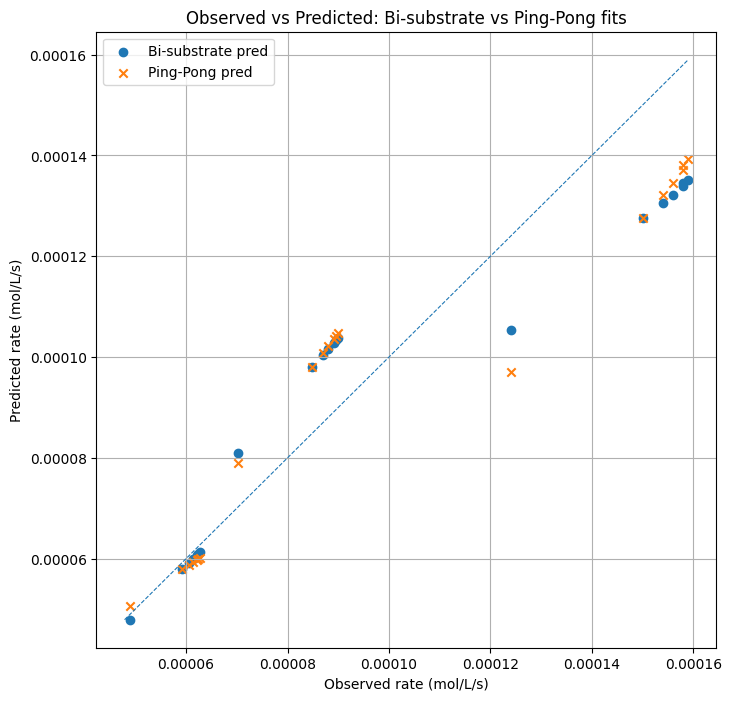

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(v_obs, v_bi_pred, label='Bi-substrate pred', marker='o')
plt.scatter(v_obs, v_pp_pred, label='Ping-Pong pred', marker='x')
minv = min(np.min(v_obs), np.min(v_bi_pred), np.min(v_pp_pred))
maxv = max(np.max(v_obs), np.max(v_bi_pred), np.max(v_pp_pred))
plt.plot([minv, maxv], [minv, maxv], '--', linewidth=0.8)
plt.xlabel('Observed rate (mol/L/s)')
plt.ylabel('Predicted rate (mol/L/s)')
plt.legend()
plt.title('Observed vs Predicted: terneary vs Ping-Pong fits')
plt.grid(True)
plt.show()

## Sir's Method

### Bi subs

In [ ]:
x = 1 / (A * B + eps)
y = 1 / (B + eps)
z = 1 / (A + eps)
con = np.ones_like(A)

x, y, z, con

(array([ 3333.33333333,   833.33333333,   555.55555556,   416.66666667,
          277.77777778,   222.22222222,   166.66666667,  5000.        ,
         1250.        ,   833.33333333,   625.        ,   416.66666667,
          333.33333333,   250.        , 10000.        ,  2500.        ,
         1666.66666667,  1250.        ,   833.33333333,   666.66666667,
          500.        ]),
 array([ 3.33333333,  3.33333333,  3.33333333,  3.33333333,  3.33333333,
         3.33333333,  3.33333333,  5.        ,  5.        ,  5.        ,
         5.        ,  5.        ,  5.        ,  5.        , 10.        ,
        10.        , 10.        , 10.        , 10.        , 10.        ,
        10.        ]),
 array([1000.        ,  250.        ,  166.66666667,  125.        ,
          83.33333333,   66.66666667,   50.        , 1000.        ,
         250.        ,  166.66666667,  125.        ,   83.33333333,
          66.66666667,   50.        , 1000.        ,  250.        ,
         166.66666667,  125

In [ ]:
mat = np.column_stack([x, y, z, con])
mat

array([[3.33333333e+03, 3.33333333e+00, 1.00000000e+03, 1.00000000e+00],
       [8.33333333e+02, 3.33333333e+00, 2.50000000e+02, 1.00000000e+00],
       [5.55555556e+02, 3.33333333e+00, 1.66666667e+02, 1.00000000e+00],
       [4.16666667e+02, 3.33333333e+00, 1.25000000e+02, 1.00000000e+00],
       [2.77777778e+02, 3.33333333e+00, 8.33333333e+01, 1.00000000e+00],
       [2.22222222e+02, 3.33333333e+00, 6.66666667e+01, 1.00000000e+00],
       [1.66666667e+02, 3.33333333e+00, 5.00000000e+01, 1.00000000e+00],
       [5.00000000e+03, 5.00000000e+00, 1.00000000e+03, 1.00000000e+00],
       [1.25000000e+03, 5.00000000e+00, 2.50000000e+02, 1.00000000e+00],
       [8.33333333e+02, 5.00000000e+00, 1.66666667e+02, 1.00000000e+00],
       [6.25000000e+02, 5.00000000e+00, 1.25000000e+02, 1.00000000e+00],
       [4.16666667e+02, 5.00000000e+00, 8.33333333e+01, 1.00000000e+00],
       [3.33333333e+02, 5.00000000e+00, 6.66666667e+01, 1.00000000e+00],
       [2.50000000e+02, 5.00000000e+00, 5.00000000e

In [ ]:
np.shape(mat)

(21, 4)

In [ ]:
# G is a 4x4 matrix
for j in range(np.shape(mat)[0]):
    for i in range(np.shape(mat)[1]):
        # g11 = sum of all x*x for all values
        # g12 = sum of all x*y foa all values
        # g13 = sum of all x*z for all vlaues
        # g14 = sum of all const
        # g21 = sum of all y*x foa ll values
        # g22 = sum of all y*y for all values
        # and so on so that a symmetric matrix is formed and als dont want sucha a big coded function a small concise one whic get the logic of g[i][j] and all and performs accordingly in a few lines

SyntaxError: incomplete input (ipython-input-2936118418.py, line 10)